# Convolution on Multi-core CPUs

When targeting CPUs, the set of possible optimizations and opportunities for parallelization are limited. You can exploit multiple cores and split your computations across those. You can exploit SIMD units in each core to further boost performance. If your CPU has an embedded GPU (for example, the Intel Iris graphics cores), it is sometimes possible to use the GPU through the OpenCL environment. These tightly-integrated GPUs share the memory space, and do not require explicit copying that is otherwise necessary for accelerators. A side benefit of using OpenCL here is the future possibility of porting to another, newer, OpenCL-compatible platform. 

We start as before, with the necessary PyOpenCL header declarations..

In [2]:
# Plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)        # medium images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

#load the ipython extensions for pyopencl
%load_ext pyopencl.ipython_ext

from __future__ import absolute_import, print_function
import pyopencl as cl

ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Intel(R) OpenCL' at 0x2108730>
[1] <pyopencl.Platform 'Clover' at 0x7fee08b20ae0>
Choice [0]:0
Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.


## 1. SIMD Vectorization:
While most OpenCL compilers will auto-vectorize simple code, it is often necessary to explicitly use OpenCL vector types for ensuring high performance. This eliminates writing low-level intrinsics, and transparently allows the same OpenCL code to run on different hardware with varying SIMD vector widths. The **float4** type is an example of the OpenCL vector type. Apart from changing the type of your operation, you have to rearrnage your inputs to fit the vector access pattern. A 2D convolution rewritten for SIMD vectorization looks like one below:


In [3]:
%%cl_kernel

__kernel void convolve2D_vector(
        __global float *in,               // W*H input images
        __global float *filt,                 // K*K filter kernel
        __global float *out)                    // W*H output images
{
        // get image resolution
        int W = get_global_size(0);
        int H = get_global_size(1);
        int K = 3;

        // get pixel position
        int x = get_global_id(0); 
        int y = get_global_id(1);

        float4 sum = 0; 
        int r=0, c=0, c4=0;
        float* filt_ptr;
        float* in_ptr;

        // loop over rows
        for (r = 0; r < K; r++) 
        {
                // loop over columns
                for(c = 0; c < K; c+=4)
                {
                        float4 filt4 = vload4(c4,filt_ptr);
                        float4 in4 = vload4(c4,in_ptr);
                        sum += filt4*in4;
                        c4++;
                        // vload4 requires const float* arguments! ugh!
                        filt_ptr += r*K*sizeof(float);
                        in_ptr += ((y+r)*W+x)*sizeof(float);
                }
                // TODO: for the odd last element..
        }
        out[y*W+x] = sum.x + sum.y + sum.z + sum.w;
}

/usr/lib/python2.7/dist-packages/pyopencl/__init__.py:63: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


The code above works well for large values of K>5. For smaller values of K<=5, we may want to avoid vectorization. We modified the loop over c, and replaced the inner portion of the loops with a vector operation. This does result in redundant data loads, but we expect (hope) caching helps reduce off-chip memory traffic. Vectorized loads are a more efficienct use of memory bandwidth as they permit coalesced access. We the run the code as before

(512, 512)


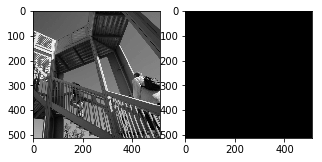

In [14]:
from scipy import ndimage, misc, signal;
import numpy as np

f = misc.ascent();
in_np = f.astype(np.float32);

filt_np = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype=np.float32);
filt_np /= sum(filt_np)

mf = cl.mem_flags
in_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=in_np)
filt_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=filt_np)
out_g = cl.Buffer(ctx, mf.WRITE_ONLY, in_np.nbytes)

# Run OpenCL convolve2D function
print(in_np.shape);
k_event = convolve2D_vector(queue, in_np.shape, None, in_g, filt_g, out_g)
k_event.wait()

out_np = np.zeros_like(in_np, dtype=np.float32)
cl.enqueue_copy(queue, out_np, out_g)

fig, (a, b) = plt.subplots(1, 2)
a.imshow(in_np, cmap='gray')
b.imshow(out_np, cmap='gray')
plt.show() # apparently, plt.show() works than fig.show() in juypter

## 2. Loop Unrolling:
We can also use loop unrolling as a way to improve performance. Loops, without extra information, are sequential operations. If the programmer (or compiler) can reason about data independence across loop iterations, we can run each loop iteration in parallel. A programmer can provide hints to the compiler about what loop to unroll and to what extent. We first show a simple manually unrolled OpenCL kernel, and its equivalent version with compiler hints.

In [5]:
%%cl_kernel

__kernel void convolve2D_unroll(
        const __global float *in,               // W*H input images
        __constant float *filt,                 // K*K filter kernel
        __global float *out)                    // W*H output images
{
        // get image resolution
        const int W = get_global_size(0);
        const int H = get_global_size(1);
        const int K = 3;

        // get pixel position
        const int x = get_global_id(0); 
        const int y = get_global_id(1);

        float sum = 0;
        int c = 0;

        // loop over rows
        for (int r = 0; r < K; r++)
        {
                // loop over columns
                // only in OpenCL 2.0 __attribute__ ((opencl unroll hint(2)))
                for(c = 0; c < K; c+=2)
                {
                        // manually unrolled
                        sum += filt[r*K+c]*in[((y+r)*W+x)+c];
                        sum += filt[r*K+c+1]*in[((y+r)*W+x)+c+1];
                }
        }
        out[y*W+x] = sum;
}

As we can see from the code blocks above we have a choice of (1) verbose, manual operation of unrolling, or (2) automated compiler-driven option. Which one would you choose? We run the code as before:

(512, 512)


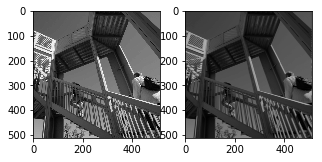

In [8]:
from scipy import ndimage, misc, signal;
import numpy as np

f = misc.ascent();
in_np = f.astype(np.float32);

filt_np = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype=np.float32);
filt_np /= sum(filt_np)

mf = cl.mem_flags
in_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=in_np)
filt_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=filt_np)
out_g = cl.Buffer(ctx, mf.WRITE_ONLY, in_np.nbytes)

# Run OpenCL convolve2D function
print(in_np.shape);
k_event = convolve2D_unroll(queue, in_np.shape, None, in_g, filt_g, out_g)
k_event.wait()

out_np = np.zeros_like(in_np, dtype=np.float32)
cl.enqueue_copy(queue, out_np, out_g)

fig, (a, b) = plt.subplots(1, 2)
a.imshow(in_np, cmap='gray')
b.imshow(out_np, cmap='gray')
plt.show() # apparently, plt.show() works than fig.show() in juypter

## 3. Thread-Level Parallelism
The final aspect of performance tuning is parallelization across cores. This is not direct or explicit under OpenCL, but can be configured by careful selection of **global** and **local** workgroup sizes. When they're equal, all work items are scheduled onto a single core. The ratio between these workgroup sizes indicates the number of threads/cores you can target. The OpenCL runtime can also be configured through **Device Fission** settings to partition the OpenCL device and restrict OpenCL operations onto a subset of available threads/cores.